## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1.Compute the camera calibration using chessboard images

In [1]:
import cv2
import numpy as np
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import advanced_lane_lines as helpers

%matplotlib qt


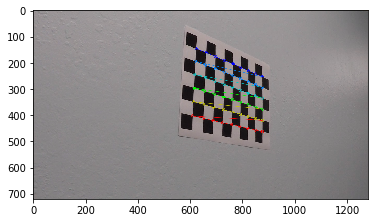

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)
        plt.imshow(img)
# cv2.destroyAllWindows()

def get_objpoints_imgpoints(images):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    return objpoints, imgpoints 
            
            

## 2. Apply a distortion correction to raw images.

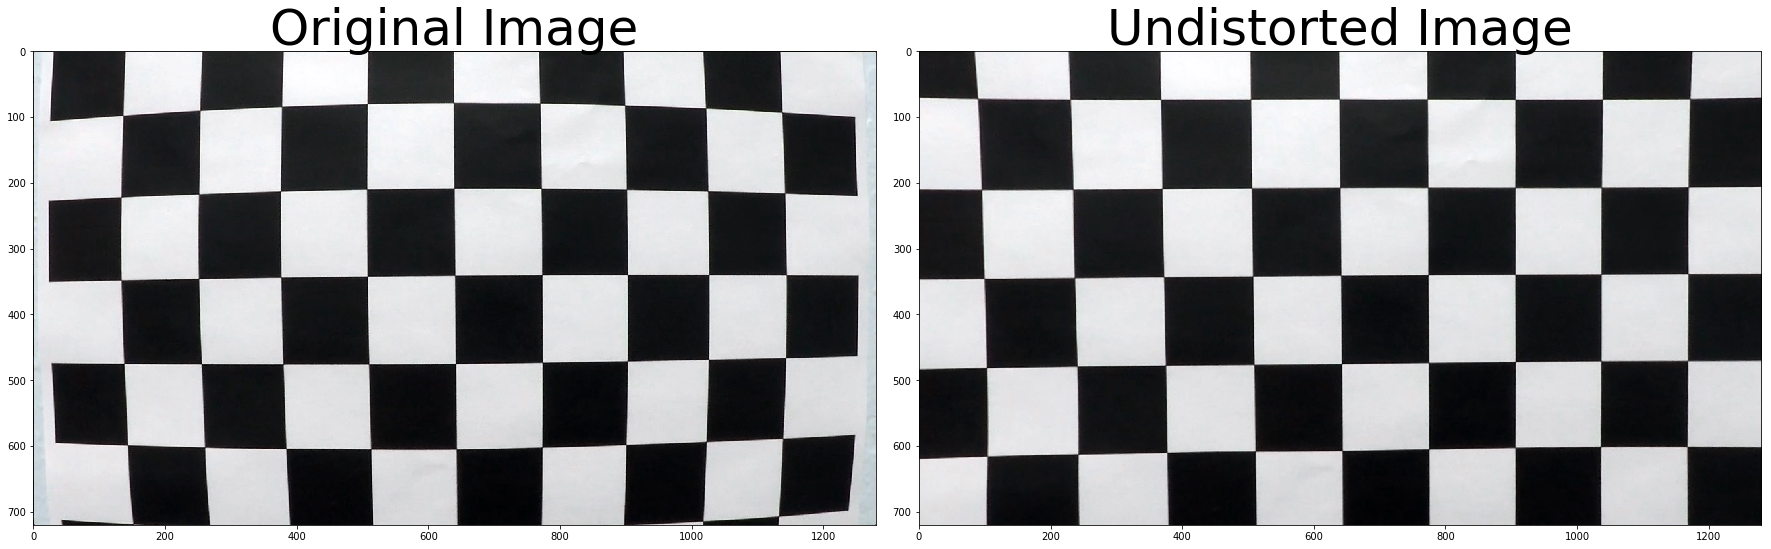

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


#========================================
#Test and show result
img = cv2.imread("./camera_cal/calibration1.jpg")

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

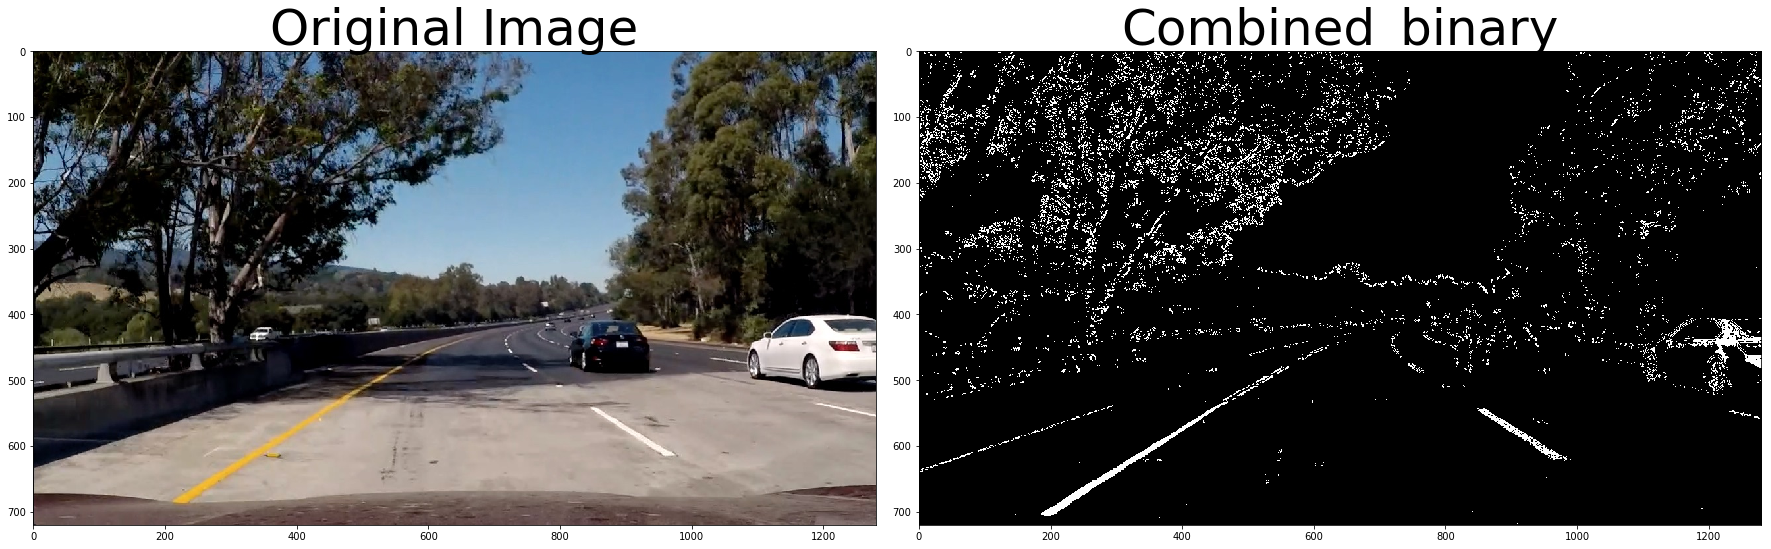

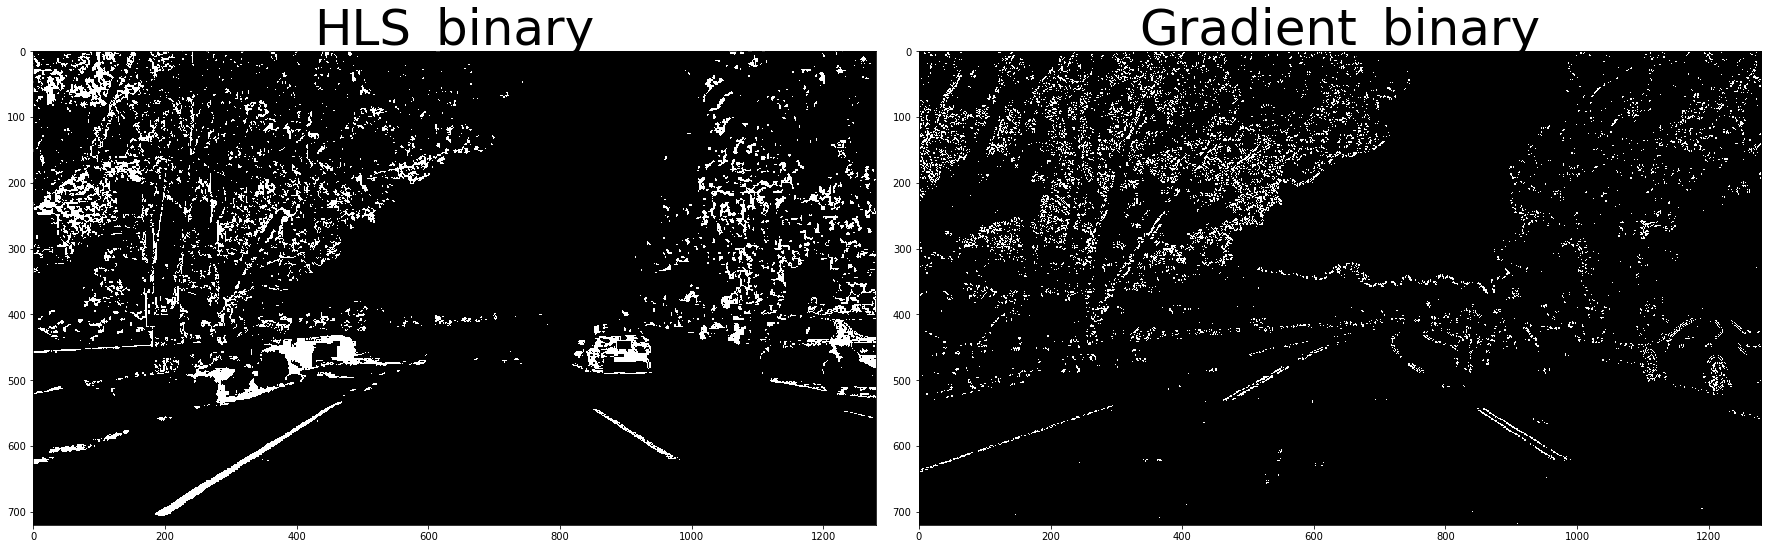

In [7]:
def comine_gradient_threshold(image, sobel_kernel=3, abs_sobel_thresh=(0, 255), mag_thresh=(0, 255),
                                    dir_threshold=(0, np.pi/2)):
    #1 Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
    
    #Absolute gradient in x and y
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    scaled_sobelx = np.uint8(abs_sobelx*255/np.max(abs_sobelx))
    scaled_sobely = np.uint8(abs_sobely*255/np.max(abs_sobely))

    #Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    abs_grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    #Calculate the gradient magnitude
    grad_mag = np.sqrt(sobelx**2, sobely**2)
    scale_factor = np.max(grad_mag)/255
    grad_mag = (grad_mag/scale_factor).astype(np.uint8)
    
    combined_binary = np.zeros_like(grad_mag)
    
#     combined_binary[((scaled_sobelx >= abs_sobel_thresh[0]) & (scaled_sobelx <= abs_sobel_thresh[1])) ] = 1
    combined_binary[(((scaled_sobelx >= abs_sobel_thresh[0]) & (scaled_sobelx <= abs_sobel_thresh[1])) 
                        & (((scaled_sobely >= abs_sobel_thresh[0]) & (scaled_sobely <= abs_sobel_thresh[1])))) ] = 1
    
    return combined_binary
    
# Read in an image
img = mpimg.imread('./test_images/test5.jpg') 
# img = mpimg.imread('./test_images/straight_lines2.jpg') 
undistorted = cal_undistort(img, objpoints, imgpoints)

gradient_binary = comine_gradient_threshold(undistorted, sobel_kernel=3, abs_sobel_thresh=(20, 100),
                                                  mag_thresh=(30, 100), dir_threshold=(0.7, 1.3))


s_thresh_min = 170
s_thresh_max = 255

r_thresh_min = 170#200
r_thresh_max = 255

#经测试:R thresh 可以去掉阴影; S thresh在光线太强的区块表现较好;
hls_binary = helpers.hls_select(undistorted, thresh=(s_thresh_min, s_thresh_max))
rgb_binary = helpers.rgb_select(undistorted, thresh=(r_thresh_min, r_thresh_max))
combined_binary = np.zeros_like(gradient_binary)
combined_binary[(hls_binary == 1) & (rgb_binary == 1) | (gradient_binary == 1)] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
# ax1.imshow(hls_binary, cmap='gray')
# ax1.imshow(gradient_binary, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined_binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
# # Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(hls_binary, cmap='gray')
ax1.set_title('HLS_binary', fontsize=50)
ax2.imshow(gradient_binary, cmap='gray')
ax2.set_title('Gradient_binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Apply a perspective transform to rectify binary image ("birds-eye view")

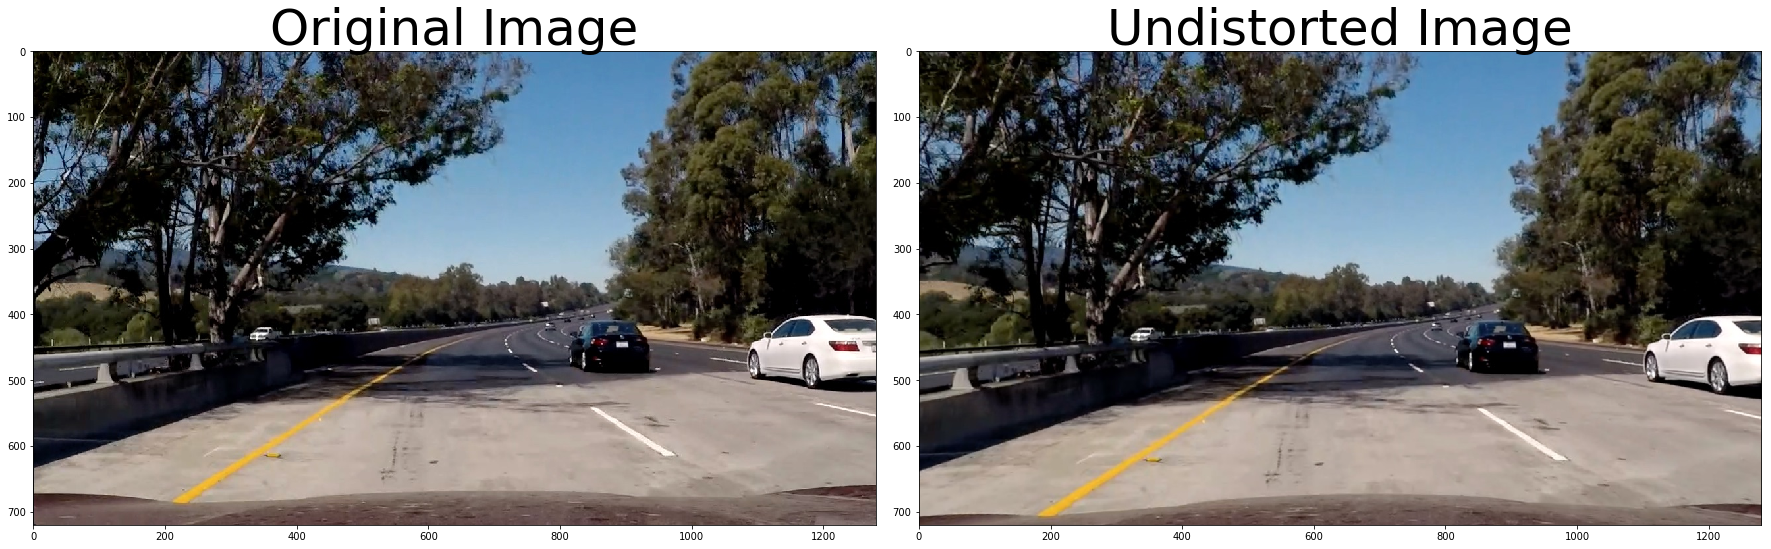

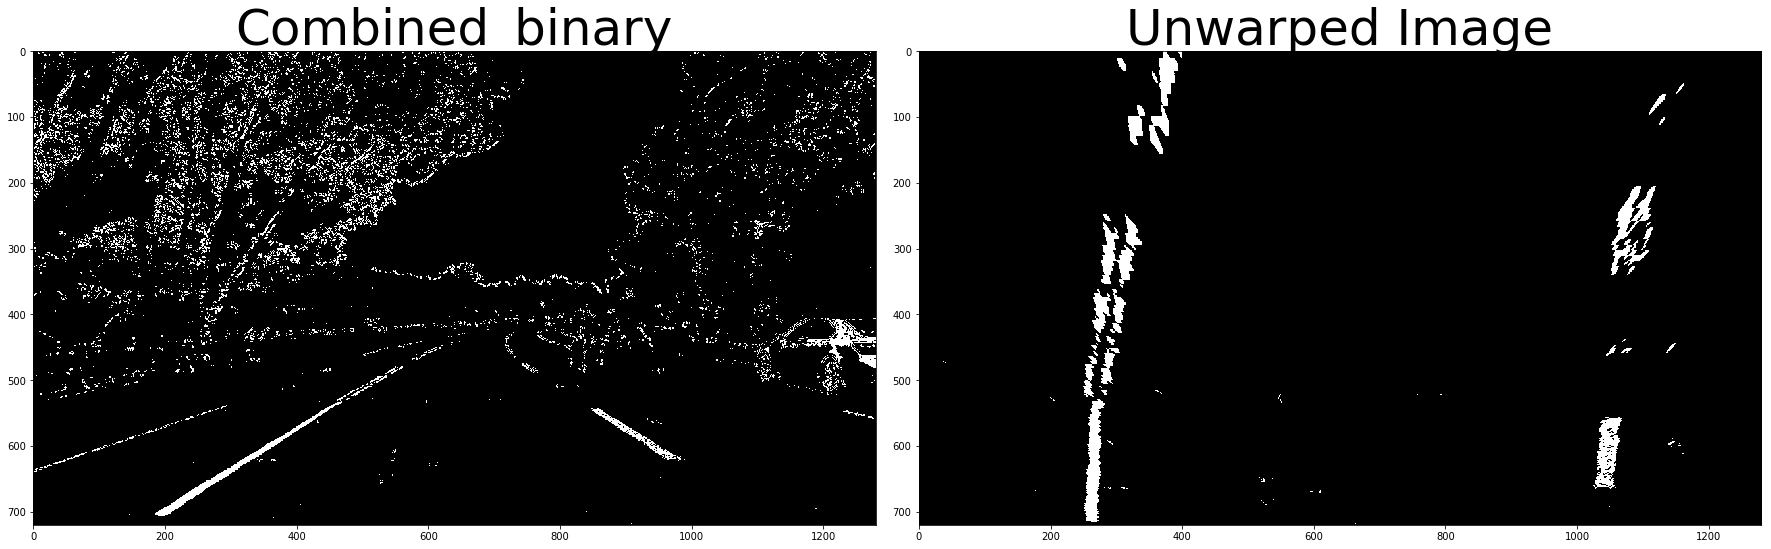

In [8]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def unwarp(undist):
    offset = 100
    img_size = (gray.shape[1], gray.shape[0])

    src = np.float32([ [240, 720],[585,460], [695, 460], [1040, 720]])
    dst = np.float32([[320, 720], [320,0], [960, 0], [960, 720] ])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inverse = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist, M, img_size)

    return warped, M_inverse

unwarped_img, M_inverse = unwarp(combined_binary)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(combined_binary, cmap='gray')
ax1.set_title('Combined_binary', fontsize=50)
ax2.imshow(unwarped_img, cmap='gray')
ax2.set_title('Unwarped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 5. Detect lane pixels and fit to find the lane boundary

In [6]:
left_lane_inds_global = []
right_lane_inds_global = []

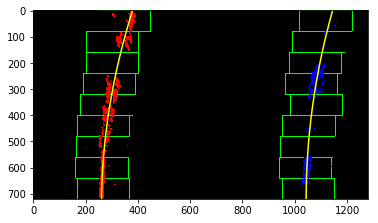

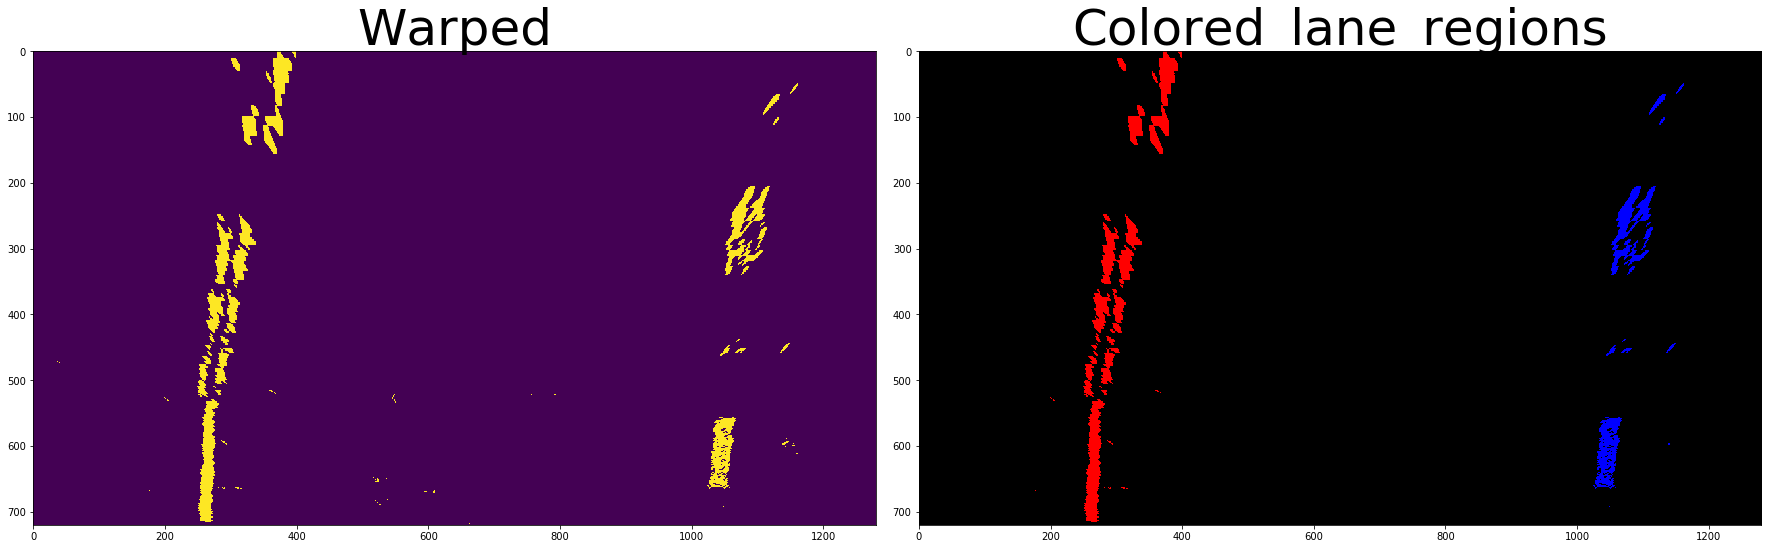

In [18]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram


def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
#     histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    histogram = hist(binary_warped)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = (np.where((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)\
                          &(nonzerox >= win_xleft_low)&(nonzerox <= win_xleft_high)))[0]

        good_right_inds = (np.where((nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)\
                          &(nonzerox >= win_xright_low)&(nonzerox <= win_xright_high)))[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if(len(good_left_inds) > minpix ):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
#             print("========leftx_current:{}".format(leftx_current))
            
        if(len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
#             print("========rightx_current:{}".format(rightx_current))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        global left_lane_inds_global
        left_lane_inds_global = left_lane_inds
        
        global right_lane_inds_global
        right_lane_inds_global = right_lane_inds
        
#         print("========left_lane_inds1:")
#         print(left_lane_inds)
        
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print("========Error")

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
#     plt.imshow(out_img)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    #second order polynomial work
    left_fit = np.polyfit(lefty,leftx, 2)
    right_fit = np.polyfit(righty,rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        print("========Error")
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    colored_lane_regions = np.zeros_like(out_img)
    colored_lane_regions[lefty, leftx] = [255, 0, 0]
    colored_lane_regions[righty, rightx] = [0, 0, 255]
    
    #For testing
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.imshow(out_img)

    
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    
    return colored_lane_regions, binary_warped, left_fitx, right_fitx, left_fit, right_fit, ploty

binary_warped = unwarped_img

#Test===================================
# Create histogram of image binary activations
histogram = hist(binary_warped)
# Visualize the resulting histogram
# plt.plot(histogram)

colored_lane_regions, warped, left_fitx, right_fitx, left_fit, right_fit, ploty = fit_polynomial(binary_warped)

# mpimg.imsave("out_img.png", out_img)

# plt.imshow(out_img)
plt.savefig('warped_example_output.png',dpi=200,bbox_inches='tight')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(warped)
ax1.set_title('Warped', fontsize=50)
ax2.imshow(colored_lane_regions)
ax2.set_title('Colored_lane_regions', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## 6. Determine the curvature of the lane and vehicle position with respect to center

In [8]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def measure_curvature_vehicle_position(unwarped_img, ploty, left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_fitx = left_fit_cr[0]*ploty**2 + left_fit_cr[1]*ploty + left_fit_cr[2]
    right_fitx = right_fit_cr[0]*ploty**2 + right_fit_cr[1]*ploty + right_fit_cr[2]
    
    ## Implement the calculation of the left line here
    left_curverad = (1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**(3/2)/np.abs(2*left_fit_cr[0])  
    
    ## Implement the calculation of the right line here
    right_curverad = (1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**(3/2)/np.abs(2*right_fit_cr[0])  
    
    curvature = (left_curverad + right_curverad)/2
    
    veh_pos = (((left_fitx[719] + right_fitx[719]) * xm_per_pix) / 2.)
    cen_pos = ((binary_warped.shape[1] * xm_per_pix) / 2.)
    distance_from_center = veh_pos - cen_pos

    return curvature, distance_from_center


# Calculate the radius of curvature in meters for both lane lines
curvature, distance_from_center = measure_curvature_vehicle_position(unwarped_img, ploty, left_fit, right_fit)
print("Radius of Curvature = %sm" % (round(curvature)))
print("Vehicle is %.3fm of center" % (abs(distance_from_center)))

Radius of Curvature = 3977.0m
Vehicle is 0.084m of center


## 7. Warp the detected lane boundaries back onto the original image

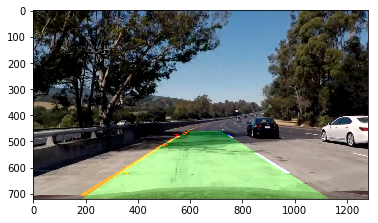

In [11]:
def warp_lane_boundaries_onto_origin(undistorted, warped, colored_lane_regions, left_fitx, right_fitx, ploty, M_inverse):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inverse, (undistorted.shape[1], undistorted.shape[0])) 
    unwarped_lane_region = cv2.warpPerspective(colored_lane_regions, M_inverse, (undistorted.shape[1], undistorted.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    result = cv2.addWeighted(result, 1, unwarped_lane_region, 0.9, 0)
    return result


#Test============================= 
result = warp_lane_boundaries_onto_origin(undistorted, warped,colored_lane_regions, left_fitx, right_fitx, ploty, M_inverse)

mpimg.imsave('./output_images/warped_output.png', result)

plt.imshow(result)
# plt.savefig('warped_output.png',dpi=400,bbox_inches='tight')    

## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

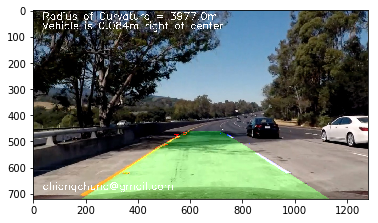

In [12]:
def draw_curvature_vehicle_position_info(img, curvature, distance_from_center):
    font = cv2.FONT_HERSHEY_SIMPLEX
    radius_text = "Radius of Curvature = %sm" % (round(curvature))

    if distance_from_center > 0:
        pos_flag = 'right'
    else:
        pos_flag = 'left'

    cv2.putText(img, radius_text, (36, 36), font, 1.3, (255, 255, 255), 2)
    center_text = "Vehicle is %.3fm %s of center" % (abs(distance_from_center), pos_flag)
    cv2.putText(img, center_text, (36, 72), font, 1.3, (255, 255, 255), 2)
    cv2.putText(img, "chiangchuna@gmail.com", (36, img.shape[0] - 36), font, 1.3, (255, 255, 255), 2)
    return img

output_img = draw_curvature_vehicle_position_info(result, curvature, distance_from_center)
mpimg.imsave('./output_images/warped_output.png', output_img)
plt.imshow(result)

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


images = glob.glob('./camera_cal/calibration*.jpg')
objpoints, imgpoints = get_objpoints_imgpoints(images)
s_thresh_min = 170
s_thresh_max = 255
    
def process_image(img):
    
    undistorted = cal_undistort(img, objpoints, imgpoints)
    
    #Use color transforms, gradients, etc., to create a thresholded binary image
    gradient_binary = comine_gradient_threshold(undistorted, sobel_kernel=3, abs_sobel_thresh=(20, 100),
                                                  mag_thresh=(30, 100), dir_threshold=(0.7, 1.3))

    hls_binary = helpers.hls_select(undistorted, thresh=(s_thresh_min, s_thresh_max))

    combined_binary = np.zeros_like(gradient_binary)
    combined_binary[(hls_binary == 1) | (gradient_binary == 1)] = 1

    #Apply perspective transform
    unwarped_img, M_inverse = unwarp(combined_binary)
    
    #Detect lane pixels and fit to find the lane boundary
    colored_lane_regions, warped, left_fitx, right_fitx, left_fit, right_fit, ploty = fit_polynomial(unwarped_img)
    
    #Warp the detected lane boundaries back onto the original image
    result = warp_lane_boundaries_onto_origin(undistorted, warped,colored_lane_regions, left_fitx, right_fitx, ploty, M_inverse)
    
    curvature, distance_from_center = measure_curvature_vehicle_position(unwarped_img, ploty, left_fit, right_fit)
    
    result = draw_curvature_vehicle_position_info(result, curvature, distance_from_center)
    
    return result

In [13]:
def process_video(src_video, output_path):
    clip1 = VideoFileClip(src_video)
    white_clip = clip1.fl_image(process_image)
    %time white_clip.write_videofile(output_path, audio=False)

### 8.1 project_video.mp4

In [22]:
src_video = "project_video.mp4"
output_path = "output_videos/test_project_video.mp4"

#Wall time: 26min 4s
test_project_video = process_video(src_video, output_path)

# test_project_video = 'output_videos/test_project_video.mp4'
# clip1 = VideoFileClip("project_video.mp4")
# white_clip = clip1.fl_image(process_image)
# %time white_clip.write_videofile(test_project_video, audio=False)

Moviepy - Building video output_videos/test_project_video.mp4.
Moviepy - Writing video output_videos/test_project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/test_project_video.mp4
Wall time: 26min 4s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_project_video))

### 8.2 challenge_video.mp4

In [19]:
src_video = "challenge_video.mp4"
output_path = "output_videos/output_challenge_video.mp4"

test_challenge_video = process_video(src_video, output_path)

Moviepy - Building video output_videos/output_challenge_video.mp4.
Moviepy - Writing video output_videos/output_challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/output_challenge_video.mp4
Wall time: 10min


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_challenge_video))

### 8.3 harder_challenge_video.mp4

In [ ]:
src_video = "harder_challenge_video.mp4"
output_path = "output_videos/output_harder_challenge_video.mp4"

test_harder_challenge_video = process_video(src_video, output_path)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_harder_challenge_video))